# Лабораторная работа №3
## Выполнили Максимов Артём и Смирнов Егор

В этой лабораторной работе мы провели анализ данных о землетресениях и провели кластеризацию этих данных по немкольким признакам и с помощью нескольких алгоритмов. 

Первым делом мы решили извлечь общую информацию о имеющихся у нас данных. 

In [1]:
import pandas as pd
import numpy as np

X = pd.read_csv('quake.csv')
stats = X.describe()
stats

Focal depth     Latitude    Longitude      Richter
count  2178.000000  2178.000000  2178.000000  2178.000000
mean     74.359963     7.961997    54.914835     5.977181
std     116.467797    30.545583   118.875581     0.189426
min       0.000000   -66.490000  -179.960000     5.800000
25%      21.000000   -12.432500   -67.782500     5.800000
50%      39.000000     0.210000   122.100000     5.900000
75%      68.000000    36.480000   146.860000     6.100000
max     656.000000    78.150000   180.000000     6.900000

Из таблицы выше видно, что в наборе из 2178 измерений по данным 4м показателям: 
- Большинство землетрясений в выборке имеет сравнительно малую глубину(75% перцентиль это 68км при том, что среднее значение глубины - 74.3км, а максимальное - 656км).
- За северным (широта > 66.34 )и южным(широта < -66.34) полярными кругами почти нет землетрясений.
- Все измерения имеют примерно одинаковую силу по шкале Рихтера, которая варьируется в пределах 1 балла(от 5.9 до 6.9).

Первый и последний пункты новодят на мысль, что эти землетрясения имеют схожую природу возникновения.

Одной из наиболее частых причин землетрясенйи являются сдвиги литосферных плит. Чтобы проверить является ли это причиной большинства землетрясений в нашем случае мы отметили на карте все землетрясения, которые есть в данных.

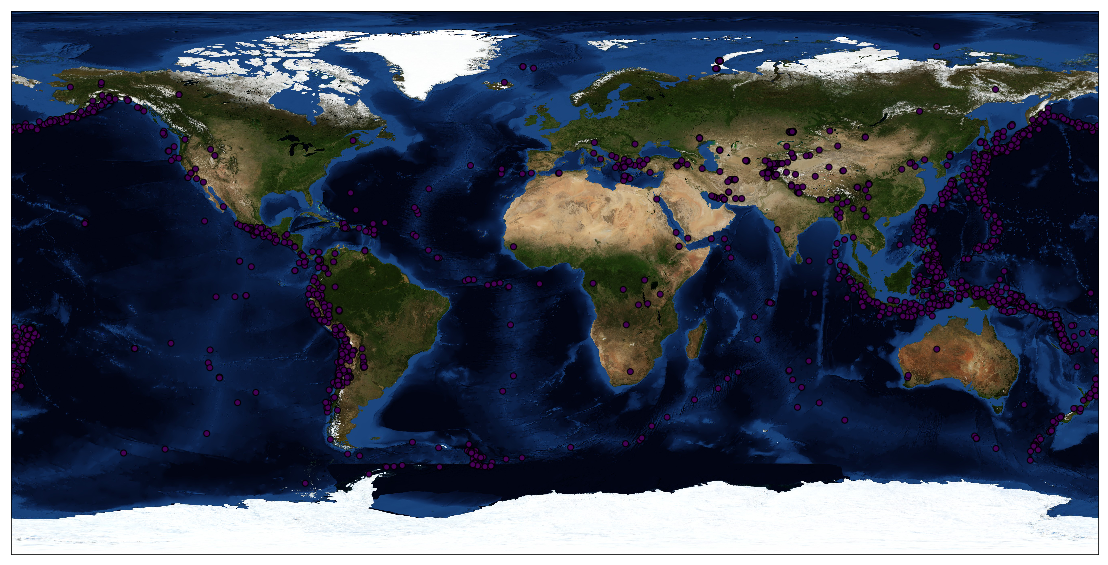

In [7]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clrs

def plotClusters(labels):    
    plt.figure(figsize=(45, 10))
    m2 = Basemap(resolution='c')
    m2.bluemarble()
    
    x, y = m2(X['Longitude'].values, X['Latitude'].values)
    m2.scatter(x, y, c=labels, marker='o', cmap='viridis', edgecolors='black', linewidths=1)
    plt.show()

labels = np.repeat(0, X.shape[0])
plotClusters(labels)

Сравнив это с первой картинкой из гугла о движении литосферных плит, легко увидеть, что это именно наш случай.

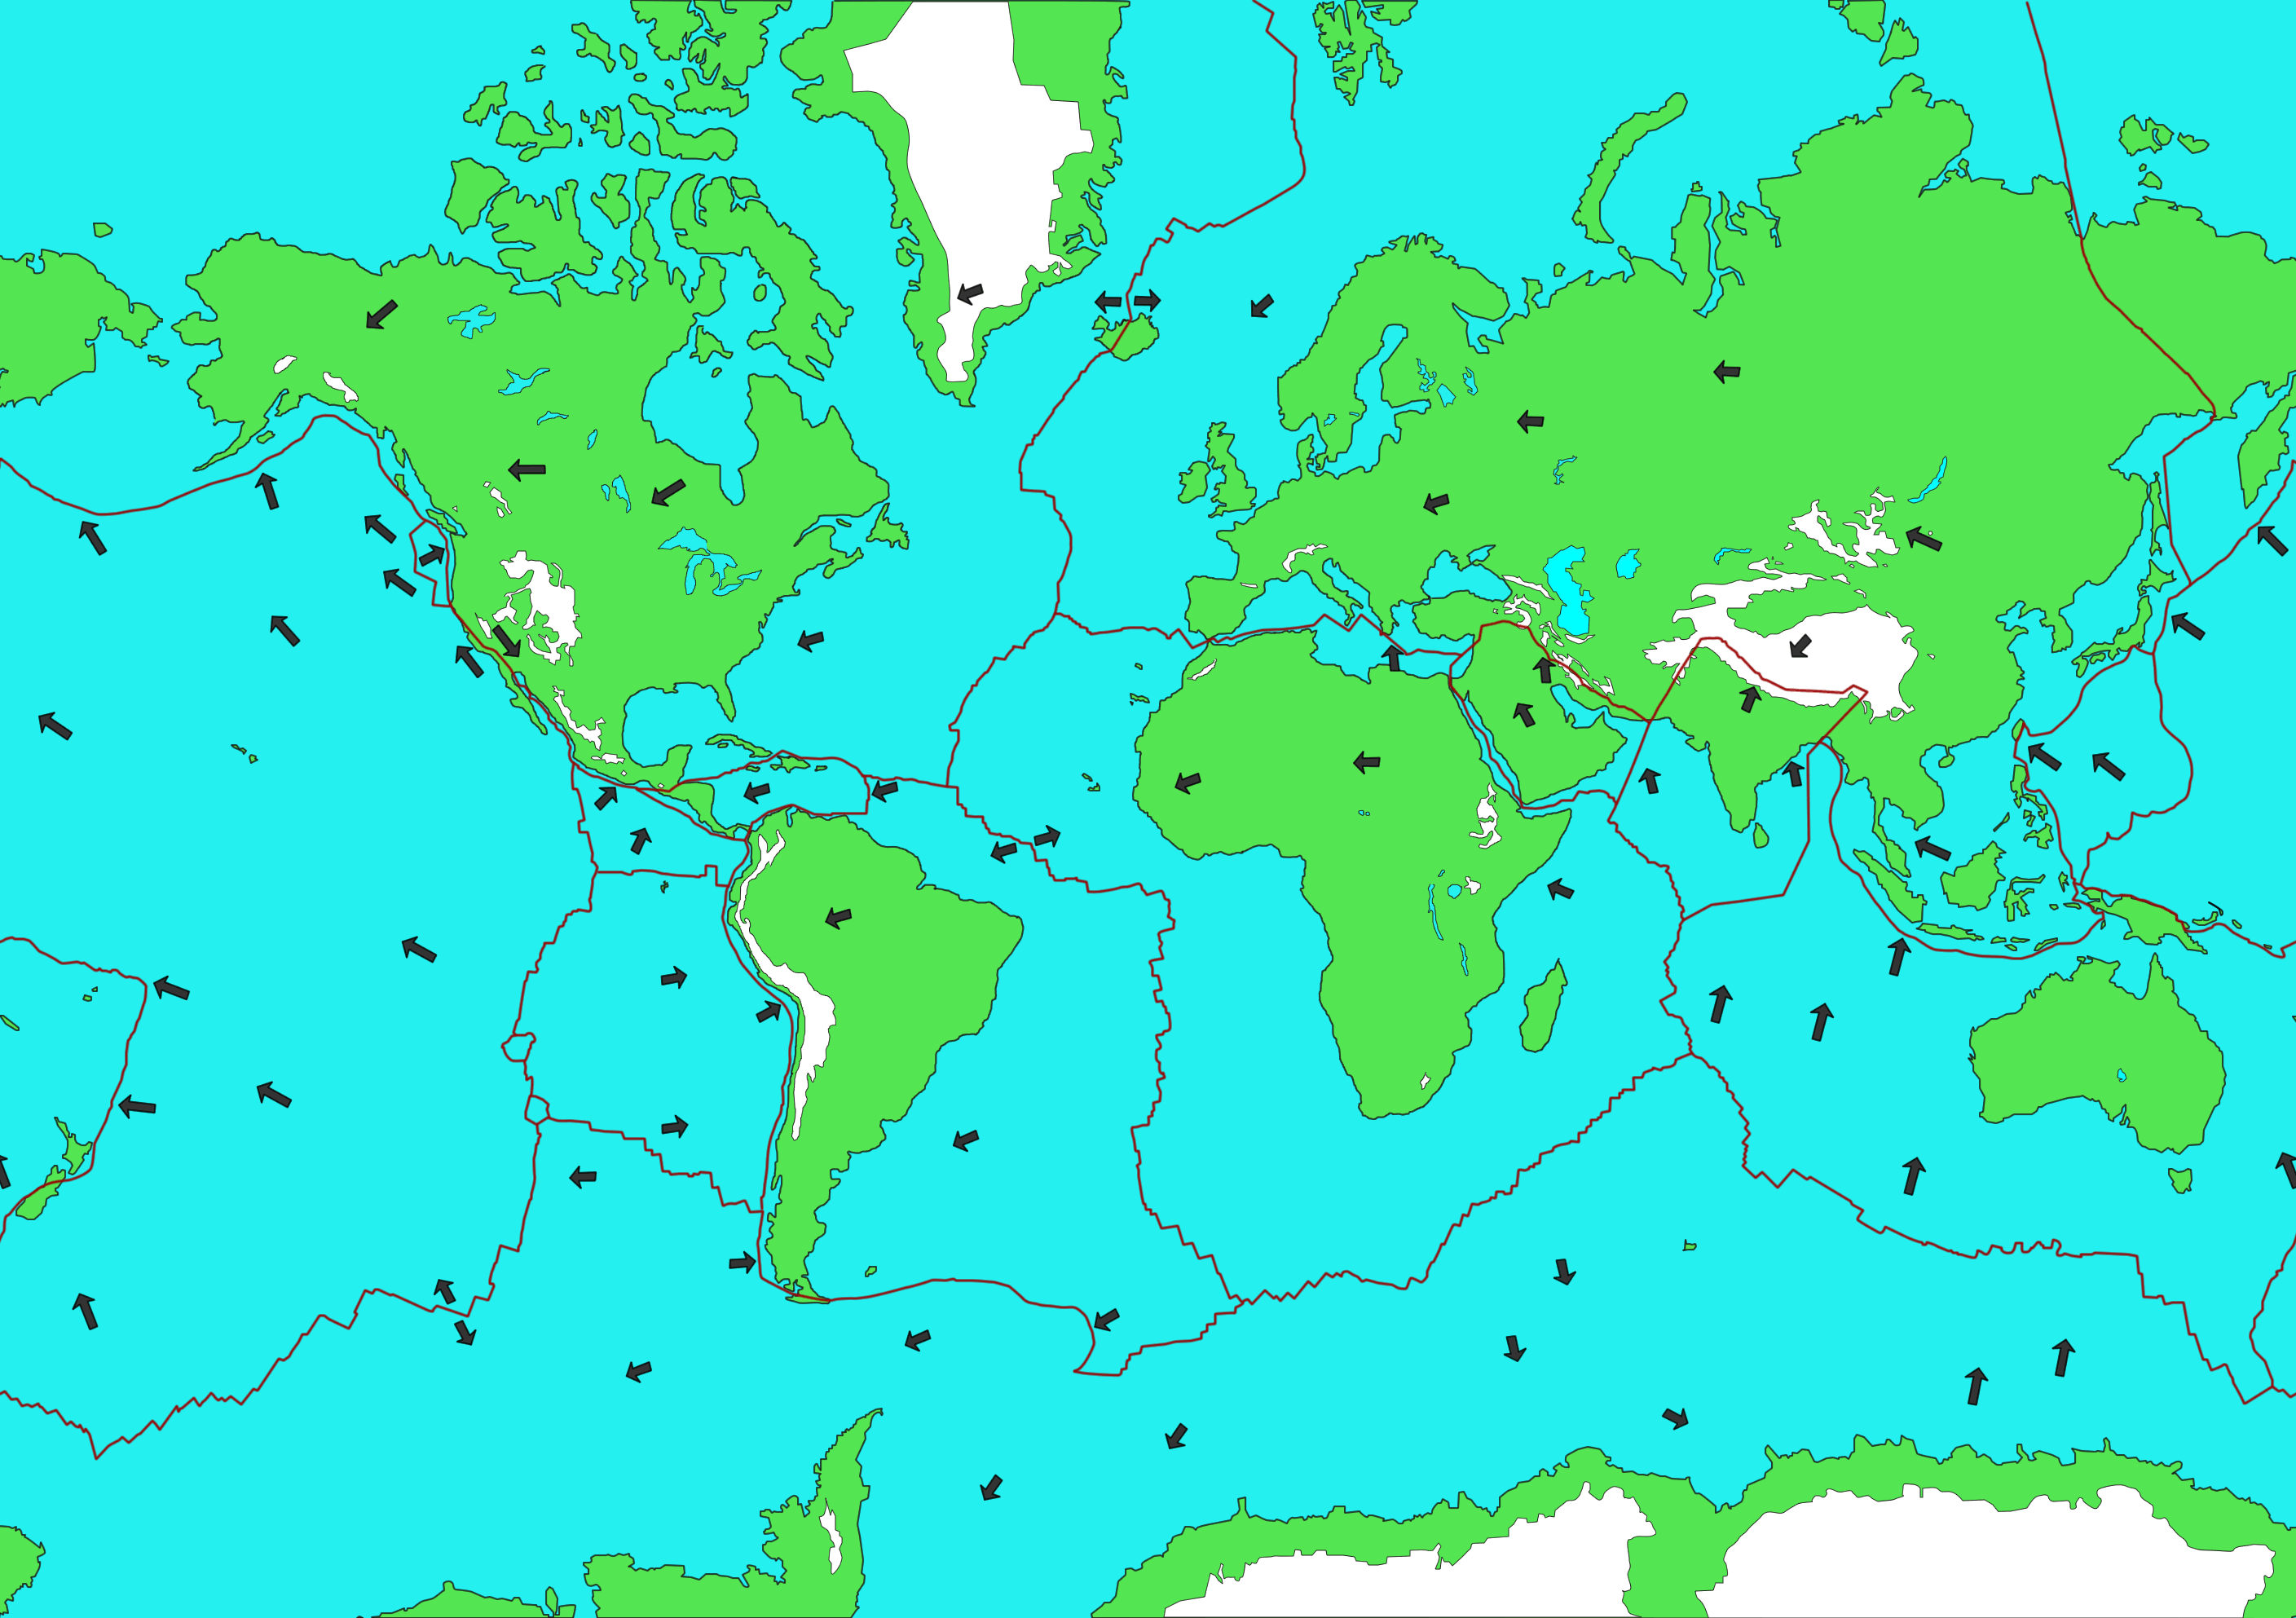

In [3]:
#пруф
from IPython.display import Image
Image(filename='earth-plates.png')

Для кластеризации были использованы следующие алгоритмы:

- K-means 
- EM
- Иерархическая кластеризация
- DBSCAN

## K - means

Этот алгоритм был выбран первым просто потому, что мы раньше уже работали с ним. 

Известно, что алгоритм K-means хорошо работает с шарообразными кластерами одинакового размера. Несмотря на то, что на карте выше не учитываются 2 признака из 4(глубина и сила по шкале Рихтера) изначально заметно, что кластеры будут иметь не шарообразную форму, а скорее вытянутую, а значит этот алгоритм не даст лучшегo результата.

Гиперпараметром для данного алгоритма является количество кластеров. На основе картинок выше мы предположили, что каждый кластер должен совпадать с фронтом движения литосферных плит(черные линии со стрелочками на фотографии). Их мы насчитали 9 штук.

Первым делом, мы запустили алгоритм только для 2 признаков - широты и долготы, чтобы убедиться, что он работает корректно и мы нигде не ошиблись.

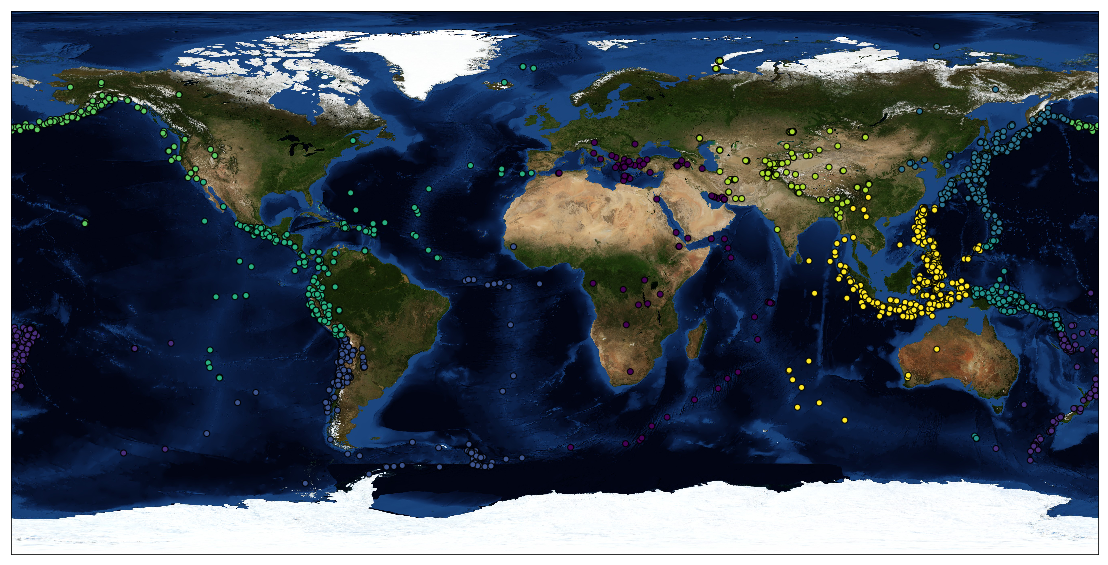

In [4]:
def plotKmeans(data, k):
    from sklearn.cluster import KMeans

    kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
    plotClusters(kmeans.labels_)

X2 = X.copy()
X2.loc[X2.Longitude < 0, 'Longitude'] += 360.0
plotKmeans(X2[['Latitude', 'Longitude']].values, 9)

Результат похож на правду, но сразу заметны 2 пары кластеров(фиолетовый - голубой и ярко-зеленый - розовый), которые должны быть двумя кластерами, но обозначены как 4. Это происходит из-за того, что по широте эти точки различаются почти на 360 и алгоритм относит их к разным кластерам.
Поэтому мы изменили данные, добавив 360 к долготе для каждой точки с отрицательной долготой.

Кластеры, которые должны были быть одним кластером объединились, значит мы все сделали правильно. 

Дальше мы запустили K-means с 4 признаками. Картинка полностью изменилась и стала такой:
    

Это случилось из-за того, что значения данных находятся в разных отрезках(глубина от 0 до 656, долгота и широта от 0 до 359, значения по шкале Рихтера от 5.9 до 6.9). Чтобы избежать этого мы нормировали все данные.

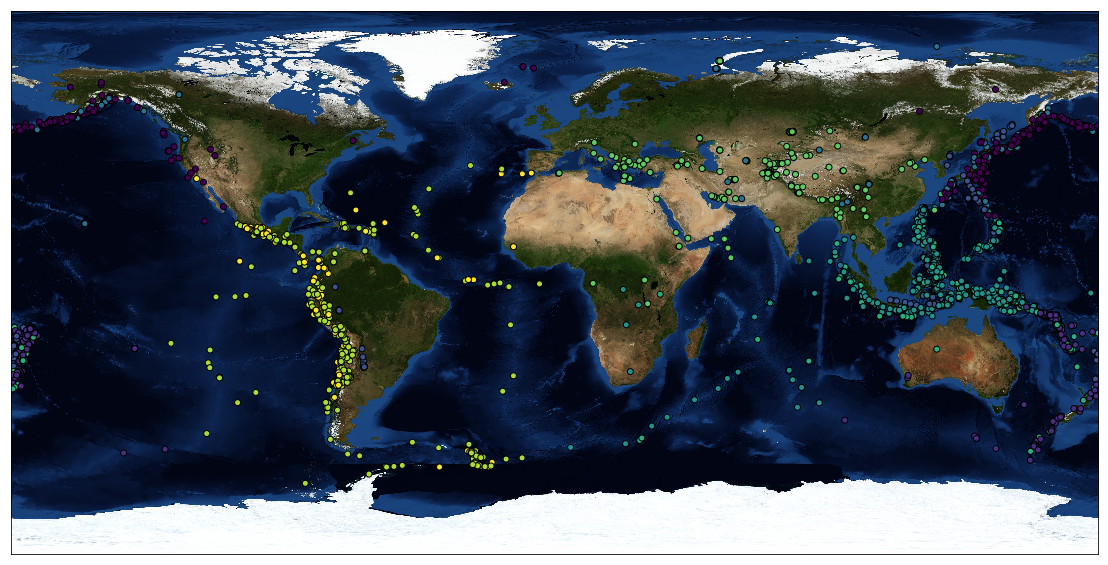

In [5]:
#очередная рофлан попытка
#Иван советовал юзать этот метод

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X2.values)
X3 = scaler.transform(X2.values, copy=True)

plotKmeans(X3, 9)

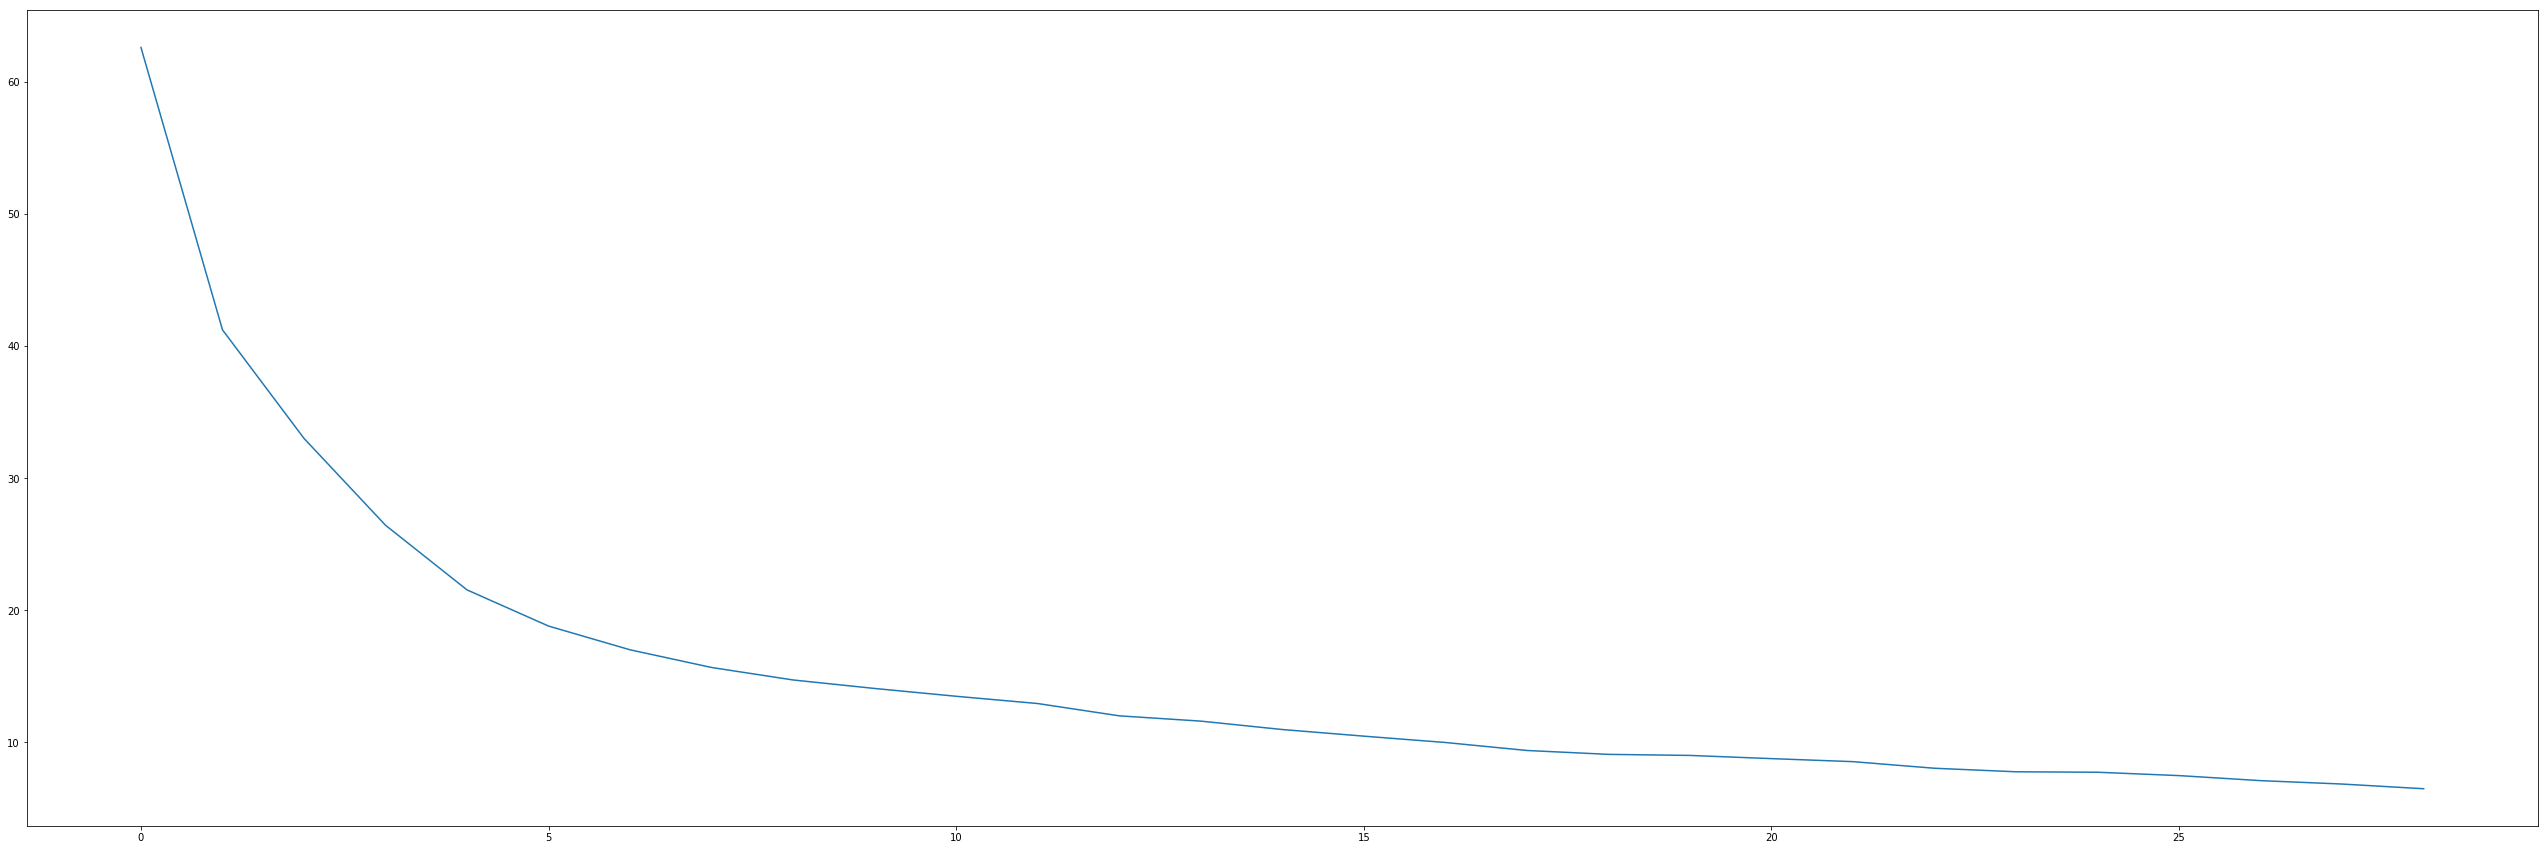

In [13]:
#Где-то надо юзануть каменистую россыпь 
from scipy import cluster

k2centroids = [cluster.vq.kmeans(X2[['Latitude', 'Longitude']].values, i) for i in range(1, 30)]

plt.figure(figsize=(45, 15))
plt.plot([var for (cent, var) in k2centroids])
plt.show()